**Making Train/ Test/ Validation Split**
-----------------------------------------

In [2]:
import os
import shutil

# Define paths
dataset_dir = '../input/celeba-dataset/'
image_dir = os.path.join(dataset_dir, 'img_align_celeba/img_align_celeba')
train_dir = 'train'
val_dir = 'validation'
test_dir = 'test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Organize files into splits
for i, filename in enumerate(os.listdir(image_dir), 1):
    src_path = os.path.join(image_dir, filename)
    if 1 <= i <= 2000:
        shutil.copy(src_path, os.path.join(train_dir, filename))
    elif 162771 <= i <= 167771:
        shutil.copy(src_path, os.path.join(val_dir, filename))
    elif 182638 <= i <= 183738:
        shutil.copy(src_path, os.path.join(test_dir, filename))


**Making Men with eyeglasses and men without eyeglasses dir**
-----------------------------------------

In [3]:
import os
import pandas as pd
import shutil

# Define paths
image_dir = 'train'  # Path to the Kaggle output directory
attribute_file = '../input/celeba-dataset/list_attr_celeba.csv'  # Path to the attribute CSV file
men_with_glasses_dir = 'men_with_glasses'
men_without_glasses_dir = 'men_without_glasses'
os.makedirs(men_with_glasses_dir, exist_ok=True)
os.makedirs(men_without_glasses_dir, exist_ok=True)

# Load the CelebA attribute CSV file
df = pd.read_csv(attribute_file)

# Filter rows corresponding to images of men
men_df = df[df['Male'] == 1]

# Further filter rows to separate men with glasses and men without glasses
men_with_glasses_df = men_df[men_df['Eyeglasses'] == 1]
men_without_glasses_df = men_df[men_df['Eyeglasses'] == -1]

# Copy images of men with glasses to the appropriate directory
for filename in men_with_glasses_df['image_id']:
    src_path = os.path.join(image_dir, filename)
    if os.path.exists(src_path):
        shutil.copy(src_path, os.path.join(men_with_glasses_dir, filename))

# Copy images of men without glasses to the appropriate directory
for filename in men_without_glasses_df['image_id']:
    src_path = os.path.join(image_dir, filename)
    if os.path.exists(src_path):
        shutil.copy(src_path, os.path.join(men_without_glasses_dir, filename))


**Train image example**
-----------------------------------------

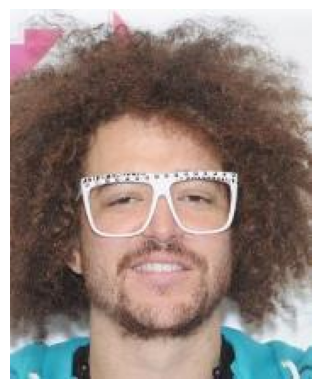

In [4]:
import os
import matplotlib.pyplot as plt

# Define the directory containing images of men with glasses
men_with_glasses_dir = 'men_with_glasses'

# Get the list of filenames for the first 5 images
image_files = os.listdir(men_with_glasses_dir)[:1]

# Plot the images
for filename in image_files:
    # Load the image
    image_path = os.path.join(men_with_glasses_dir, filename)
    image = plt.imread(image_path)
    
    # Plot the image
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()


**defining train loader**
-----------------------------------------

In [ ]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import random
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU not found. Using CPU.")
def load_train_images(trainA, trainB):
    images_type_A = []
    images_type_B = []

    # Load images from the directory trainA
    for filename in os.listdir(trainA):
        if filename.endswith('.jpg'):
            img_path = os.path.join(trainA, filename)
            img = imread(img_path, plugin='matplotlib')

            # Ensure pixel values are in the range [0, 255]
            img = img.astype(np.float32) / 255.0

            images_type_A.append(img)
    
    for filename in os.listdir(trainB):
        if filename.endswith('.jpg'):
            img_path = os.path.join(trainB, filename)
            img = imread(img_path, plugin='matplotlib')

            # Ensure pixel values are in the range [0, 255]
            img = img.astype(np.float32) / 255.0

            images_type_B.append(img)

    processed_imagesA = []
    processed_imagesB = []

    for imA, imB in zip(images_type_A, images_type_B):
        # Resize images to 128x128
        imA_resized = resize(imA, (128, 128))
        imB_resized = resize(imB, (128, 128))

        # Normalize image values between -1 and 1
        imA_normalized = imA_resized * 2 - 1
        imB_normalized = imB_resized * 2 - 1


        processed_imagesA.append(imA_normalized)
        processed_imagesB.append(imB_normalized)

    processed_imagesA = np.array(processed_imagesA)
    processed_imagesB = np.array(processed_imagesB)

    return processed_imagesA, processed_imagesB


In [ ]:
men_with_glasses_dir = 'men_with_glasses'
men_without_glasses_dir = 'men_without_glasses'
trainA, trainB = load_train_images(men_with_glasses_dir,men_without_glasses_dir)


**Making Cycle Gan functions**
-----------------------------------------

In [10]:
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, ZeroPadding2D, BatchNormalization, Add
from keras import Input, Model

from keras.layers import BatchNormalization

def resnet_block(x):    
    x2 = Conv2D(filters=256, kernel_size=3, strides=1, padding="same")(x)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    x2 = Conv2D(filters=256, kernel_size=3, strides=1, padding="same")(x2)
    x2 = BatchNormalization()(x2)

    return Add()([x2, x])


def define_generator_network(num_resnet_blocks=9):
    input_size = (128, 128, 3)
    
    # Input RGB image 
    input_layer = Input(shape=input_size)

    # Down-sampling using conv2d
    x = Conv2D(filters=64, kernel_size=7, strides=1, padding="same")(input_layer)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=256, kernel_size=3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Transforming the hidden representation using the resnet blocks
    for _ in range(num_resnet_blocks):
        x = resnet_block(x)
    
    # Upsampling to recover the transformed image
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=3, kernel_size=7, strides=1, padding="same")(x)
    output = Activation('tanh')(x)  # tanh activation to get normalized output image

    model = Model(inputs=[input_layer], outputs=[output])
    return model


# Define the discriminator network based on the PatchGAN's architecture
from keras.layers import BatchNormalization

# Define discriminator network
def define_discriminator_network():
    input_size = (128, 128, 3)
    num_hidden_layers = 3
    input_layer = Input(shape=input_size)

    x = ZeroPadding2D(padding=(1, 1))(input_layer)

    x = Conv2D(filters=64, kernel_size=4, strides=2, padding="valid")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = ZeroPadding2D(padding=(1, 1))(x)

    for i in range(1, num_hidden_layers + 1):
        x = Conv2D(filters=2 ** i * 64, kernel_size=4, strides=2, padding="valid")(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = ZeroPadding2D(padding=(1, 1))(x)

    # Sigmoid activation to normalize output values between 0 and 1 which will be used to train real or fake labels
    output = Conv2D(filters=1, kernel_size=4, strides=1, activation="sigmoid")(x)  # This is the patch output

    model = Model(inputs=[input_layer], outputs=[output])
    return model


def define_adversarial_model(generatorA2B, generatorB2A, discriminatorA, discriminatorB, train_optimizer, lambda_cyc=10, lambda_idt=5):
    inA = Input(shape=(128, 128, 3))
    inB = Input(shape=(128, 128, 3))

    fakeB = generatorA2B(inA)
    fakeA = generatorB2A(inB)

    reconstructedA = generatorB2A(fakeB)
    reconstructedB = generatorA2B(fakeA)

    identityA = generatorB2A(inA)
    identityB = generatorA2B(inB)

    decisionA = discriminatorA(fakeA)
    decisionB = discriminatorB(fakeB)
    print(type(decisionA), type(decisionB), type(reconstructedA), type(reconstructedB), type(identityA), type(identityB))

    adversarial_model = Model(inputs=[inA, inB], 
                              outputs=[decisionA[0], decisionB[0], reconstructedA[0], reconstructedB[0], identityA[0], identityB[0]])
    adversarial_model.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'], 
                              loss_weights=[1, 1, lambda_cyc, lambda_cyc, lambda_idt, lambda_idt],
                              optimizer=train_optimizer)
    print(adversarial_model.summary())
    return adversarial_model






In [11]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import torch
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Num GPUs Available:  2
True


**Making Test loader**
-----------------------------------------

In [13]:


import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import imageio.v2 as imageio


def load_test_images(testA, testB, num_images):
    images_type_A = []
    images_type_B = []

    # Load images from the directories testA and testB
    for filename in os.listdir(testA):
        if filename.endswith('.jpg'):
            img_path = os.path.join(testA, filename)
            img = imageio.imread(img_path)
            
            # Ensure pixel values are in the range [0, 255]
            img = img.astype(np.float32) / 255.0

            images_type_A.append(img)

    for filename in os.listdir(testB):
        if filename.endswith('.jpg'):
            img_path = os.path.join(testB, filename)
            img = imageio.imread(img_path)
            
            # Ensure pixel values are in the range [0, 255]
            img = img.astype(np.float32) / 255.0

            images_type_B.append(img)

    # Shuffle the lists of images
    np.random.shuffle(images_type_A)
    np.random.shuffle(images_type_B)

    # Select a subset of images
    images_type_A = images_type_A[:num_images]
    images_type_B = images_type_B[:num_images]

    processed_imagesA = []
    processed_imagesB = []

    for imA, imB in zip(images_type_A, images_type_B):
        # Resize images to 128x128
        imA_resized = resize(imA, (128, 128))
        imB_resized = resize(imB, (128, 128))

        # Normalize image values between -1 and 1
        imA_normalized = imA_resized * 2 - 1
        imB_normalized = imB_resized * 2 - 1

        processed_imagesA.append(imA_normalized)
        processed_imagesB.append(imB_normalized)

    processed_imagesA = np.array(processed_imagesA)
    processed_imagesB = np.array(processed_imagesB)

    return processed_imagesA, processed_imagesB



In [14]:
men_with_glasses_dir = 'men_with_glasses_test'
men_without_glasses_dir = 'men_without_glasses_test'
testA, testB = load_test_images(men_with_glasses_dir,men_without_glasses_dir, num_images=2)

**Test image example**
-----------------------------------------

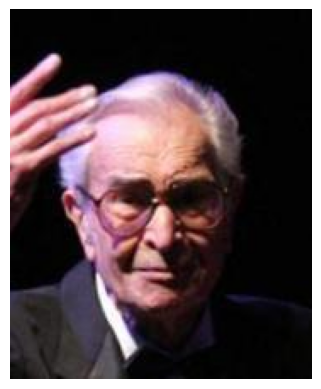

In [15]:
import os
import matplotlib.pyplot as plt

# Define the directory containing images of men with glasses
men_with_glasses_dir = 'men_with_glasses_test'

# Get the list of filenames for the first 5 images
image_files = os.listdir(men_with_glasses_dir)[:1]

# Plot the images
for filename in image_files:
    # Load the image
    image_path = os.path.join(men_with_glasses_dir, filename)
    image = plt.imread(image_path)
    
    # Plot the image
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [25]:
import numpy as np
import glob
from matplotlib.image import imread
from skimage.transform import resize
import tensorflow as tf
import matplotlib.pyplot as plt

def save_losses_tensorboard(callback, name, loss, batch_no):
    callback.add_scalar(name, loss, batch_no)
    callback.flush()



import os

def save_test_results(realA, realB, fakeA, fakeB, reconsA, reconsB, identityA, identityB):
    # Create directory if it doesn't exist
    if not os.path.exists("results/m2f"):
        os.makedirs("results/m2f")
    
    if not os.path.exists("results/f2m"):
        os.makedirs("results/f2m")

    for i in range(len(realA)):
#         fig = plt.figure()            
#         plt.imshow(realA[i])
#         plt.axis('off')
#         plt.text(0, 10, 'Real', color='white', fontsize=12, ha='left')
#         plt.savefig("results/m2f/real_{}.png".format(i), bbox_inches='tight')
#         fig2 = plt.figure()
#         plt.imshow(fakeB[i])
#         plt.axis('off')
#         plt.text(0, 10, 'Fake', color='white', fontsize=12, ha='left')
#         plt.savefig("results/m2f/fake_{}.png".format(i), bbox_inches='tight')
#         fig3 = plt.figure()
#         plt.imshow(reconsA[i])
#         plt.axis('off')
#         plt.text(0, 10, 'Reconstructed', color='white', fontsize=12, ha='left')
#         plt.savefig("results/m2f/recons_{}.png".format(i), bbox_inches='tight')
#         fig4 = plt.figure()
#         plt.imshow(identityA[i])
#         plt.axis('off')
#         plt.text(0, 10, 'Identity', color='white', fontsize=12, ha='left')
#         plt.savefig("results/m2f/identity_{}.png".format(i), bbox_inches='tight')
#         fig = plt.figure()            
        plt.imshow(realB[i])
        plt.axis('off')
        plt.text(0, 10, 'Real', color='white', fontsize=12, ha='left')
        plt.savefig("results/f2m/real_{}.png".format(i), bbox_inches='tight')
        fig2 = plt.figure()
        plt.imshow(fakeA[i])
        plt.axis('off')
        plt.text(0, 10, 'Fake', color='white', fontsize=12, ha='left')
        plt.savefig("results/f2m/fake_{}.png".format(i), bbox_inches='tight')
        fig3 = plt.figure()
#         plt.imshow(reconsB[i])
#         plt.axis('off')
#         plt.text(0, 10, 'Reconstructed', color='white', fontsize=12, ha='left')
#         plt.savefig("results/f2m/recons_{}.png".format(i), bbox_inches='tight')
#         fig4 = plt.figure()
#         plt.imshow(identityB[i])
#         plt.axis('off')
#         plt.text(0, 10, 'Identity', color='white', fontsize=12, ha='left')
#         plt.savefig("results/f2m/identity_{}.png".format(i), bbox_inches='tight')




/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


h
<class 'list'> <class 'list'> <class 'list'> <class 'list'> <class 'list'> <class 'list'>


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 128, 128,  │ 11,398,979 │ input_layer_5[0]… │
│ (Functional)        │ 3)                │            │ functional_5[0][… │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 128, 128,  │ 11,398,979 │ input_layer_4[0]… │
│ (Functional)        │ 3)                │            │ functional_7[0][… │
│                     │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 7, 7, 1)   │  2,768,321 │ functional_7[0][… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 7, 7, 1)   │  2,768,321 │ functional_5[0][… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,334,600 (108.09 MB)

 Trainable params: 22,776,966 (86.89 MB)

 Non-trainable params: 5,557,634 (21.20 MB)

None
Batch Size: 1
Num of ResNet Blocks: 9
Starting training for 1 epochs with lambda_cyc = 10, lambda_idt = 5, num_resnet_blocks = 9
Epoch:0
Number of batches:105 in each epoch
Batch:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1714494188.411407     156 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:77: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Total Discriminator Loss:[0.24947986 0.56122446]
Adversarial Model losses:19.619430541992188
Batch:1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Total Discriminator Loss:[0.24979419 0.517432  ]
Adversarial Model losses:18.70244789123535
Batch:2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Total Discriminator Loss:[0.24991775 0.51377547]
Adversarial Model losses:18.05559539794922
Batch:3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Total Discriminator Loss:[0.24964508 0.5344387 ]
Adversarial Model losses:17.905784606933594
Batch:4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Total Discriminator Loss:[0.24960987 0.5382653 ]
Adversarial Model losses:17.311941146850586
Batch:5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Total Discriminator Loss:[0.24960107 0.531965  ]
Adversarial Model losses:16.623701095581055
Batch:6
1/1 ━━━━━━━━━━━━

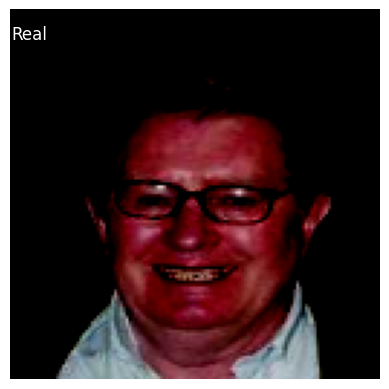

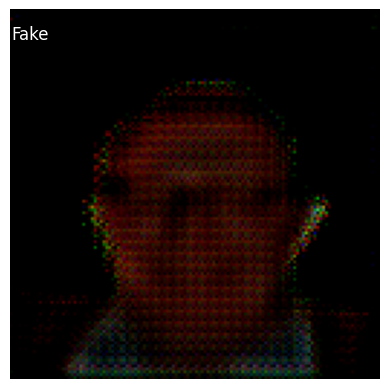

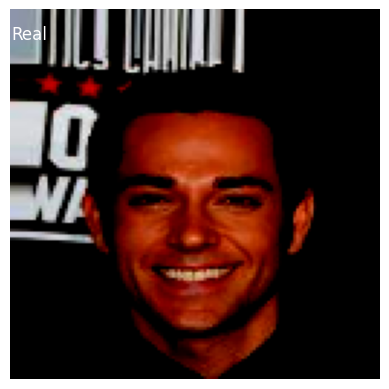

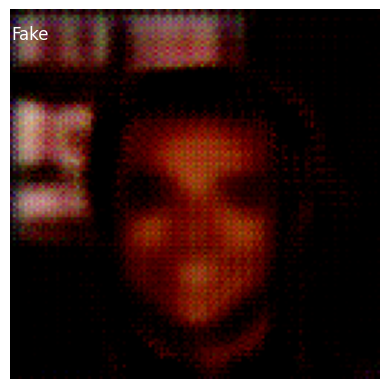

<Figure size 640x480 with 0 Axes>

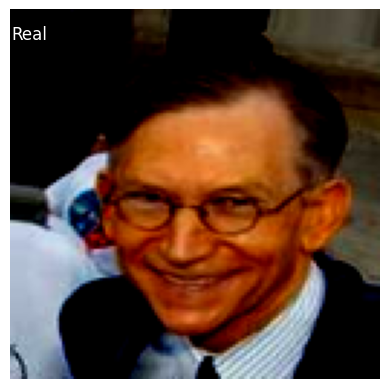

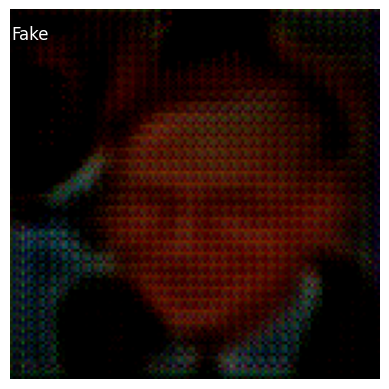

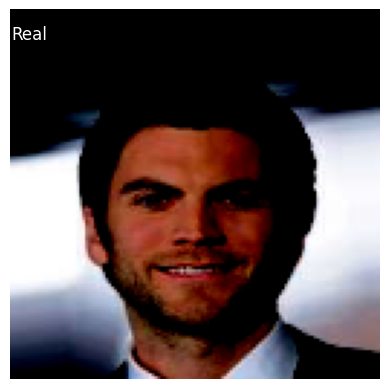

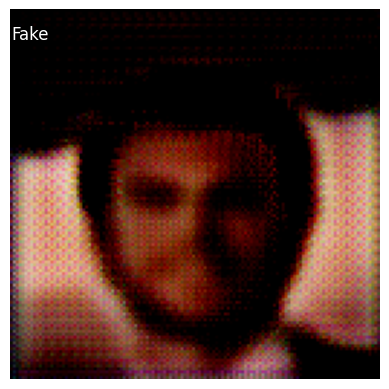

<Figure size 640x480 with 0 Axes>

In [18]:
if __name__ == '__main__':

    
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--batchSize', type=int, default=1, help='Batch Size to be used for training')
    parser.add_argument('--epochs', type=int, default=1, help='Number of epochs that training should run')
    parser.add_argument('--lambda_cyc', type=int, default=10, help='lambda value for cycle consistency loss')
    parser.add_argument('--lambda_idt', type=int, default=5, help='lambda value for identity loss')
    parser.add_argument('--save_epoch_freq', type=int, default=5, help='The frequency at which model should be saved and evaluated')
    parser.add_argument('--num_resnet_blocks', type=int, default=9, help='Number of ResNet blocks for transformation in generator')
    parser.add_argument('--data_dir', type=str, default='../output/kaggle/working', help='Directory where train and test images are present')

    opt, _ = parser.parse_known_args()
    

    data_dir = opt.data_dir #"data/male_female/"
    batch_size = opt.batchSize#2
    epochs = opt.epochs#40
    lambda_cyc = opt.lambda_cyc#10
    lambda_idt = opt.lambda_idt#5
    save_epoch_freq = opt.save_epoch_freq#5
    num_resnet_blocks = opt.num_resnet_blocks#9

    

    train_optimizer = Adam(0.0002, 0.5)

    # Define the discriminator models
    discA = define_discriminator_network()
    discB = define_discriminator_network()

#     print(discA.summary())

    # Compile the discriminator models
    discA.compile(loss='mse', optimizer=train_optimizer, metrics=['accuracy'])
    discB.compile(loss='mse', optimizer=train_optimizer, metrics=['accuracy'])

    real_labels = np.ones((batch_size, 7, 7, 1))
    fake_labels = np.zeros((batch_size, 7, 7, 1))

    # Define the generator models
    genA2B = define_generator_network(num_resnet_blocks=num_resnet_blocks)
    genB2A = define_generator_network(num_resnet_blocks=num_resnet_blocks)

#     print(genA2B.summary())

    # Make the discriminators non-trainable in the adversarial model
    discA.trainable = False
    discB.trainable = False
    print("h")
    # Define the adversarial model
    gan_model = define_adversarial_model(genA2B, genB2A, discA, discB, train_optimizer, lambda_cyc=lambda_cyc, lambda_idt=lambda_idt)

    # Setup TensorBoard
    tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()), write_images=True, write_graph=True)

    tensorboard.set_model(genA2B)
    tensorboard.set_model(genB2A)
    tensorboard.set_model(discA)
    tensorboard.set_model(discB)

    print("Batch Size: {}".format(batch_size))
    print("Num of ResNet Blocks: {}".format(num_resnet_blocks))
    print("Starting training for {0} epochs with lambda_cyc = {1}, lambda_idt = {2}, num_resnet_blocks = {3}".format(epochs, lambda_cyc, lambda_idt, num_resnet_blocks))

    # Start training
    for epoch in range(epochs):
        print("Epoch:{}".format(epoch))
        start_time = time.time()

        dis_losses = []
        gen_losses = []

        num_batches = int(min(trainA.shape[0], trainB.shape[0]) / batch_size)
        print("Number of batches:{} in each epoch".format(num_batches))

        for index in range(num_batches):
            print("Batch:{}".format(index))

            # Sample images
            realA = trainA[index * batch_size:(index + 1) * batch_size]
            realB = trainB[index * batch_size:(index + 1) * batch_size]

            # Translate images to opposite domain
            fakeB = genA2B.predict(realA)
            fakeA = genB2A.predict(realB)

            # Train the discriminator A on real and fake images
            dLossA_real = discA.train_on_batch(realA, real_labels)
            dLossA_fake = discA.train_on_batch(fakeA, fake_labels)

            # Train the discriminator B on real and fake images
            dLossB_real = discB.train_on_batch(realB, real_labels)
            dLossB_fake = discB.train_on_batch(fakeB, fake_labels)

            # Calculate the total discriminator loss
            mean_disc_loss = 0.5 * np.add(0.5 * np.add(dLossA_real, dLossA_fake), 0.5 * np.add(dLossB_real, dLossB_fake))

            print("Total Discriminator Loss:{}".format(mean_disc_loss))

            # Train the generator networks
            g_loss = gan_model.train_on_batch([realA, realB], [real_labels, real_labels, realA, realB, realA, realB])

            print("Adversarial Model losses:{}".format(g_loss))

            dis_losses.append(mean_disc_loss)
            gen_losses.append(g_loss)

        # Save losses to TensorBoard for that epoch
#         save_losses_tensorboard(tensorboard, 'discriminatorA_loss', np.mean(0.5 * np.add(dLossA_real, dLossA_fake)), epoch)
#         save_losses_tensorboard(tensorboard, 'discriminatorB_loss', np.mean(0.5 * np.add(dLossB_real, dLossB_fake)), epoch)
#         save_losses_tensorboard(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
#         save_losses_tensorboard(tensorboard, 'generator_loss', np.mean(gen_losses), epoch)

        if epoch % save_epoch_freq == 0:
            # Load Test images for seeing the results of the network
            men_with_glasses_dir = 'men_with_glasses_test'
            men_without_glasses_dir = 'men_without_glasses_test'
            testA, testB = load_test_images(men_with_glasses_dir,men_without_glasses_dir, num_images=2)

            # Generate images
            fakeB = genA2B.predict(testA)
            fakeA = genB2A.predict(testB)

            # Get reconstructed images
            reconsA = genB2A.predict(fakeB)
            reconsB = genA2B.predict(fakeA)

            identityA = genB2A.predict(testA)
            identityB = genA2B.predict(testB)

            genA2B.save('generatorAToB_temp_%d.h5' % epoch)
            genB2A.save('generatorBToA_temp_%d.h5' % epoch)
            discA.save('discriminatorA_temp_%d.h5' % epoch)
            discB.save('discriminatorB_temp_%d.h5' % epoch)
            save_test_results(testA, testB, fakeA, fakeB, reconsA, reconsA, identityA, identityB)

        print("--- %s seconds --- for epoch" % (time.time() - start_time))

    print("Training completed. Saving weights.")
    genA2B.save('generatorAToB.h5')
    genB2A.save('generatorBToA.h5')
    discA.save('discriminatorA.h5')
    discB.save('discriminatorB.h5')


Data_dir:../output/kaggle/working
BatchSize:1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


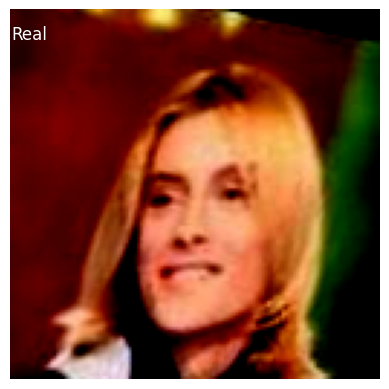

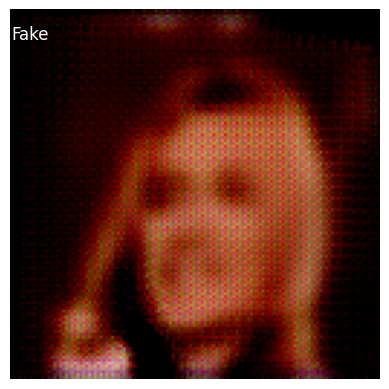

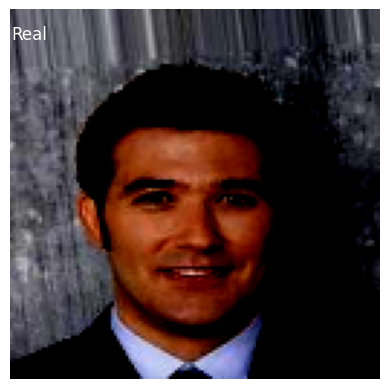

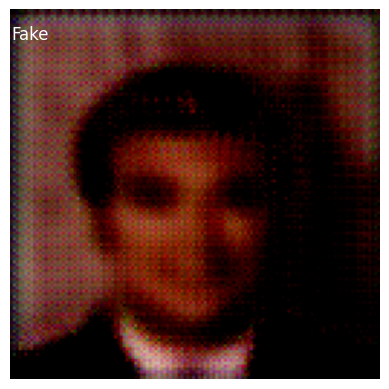

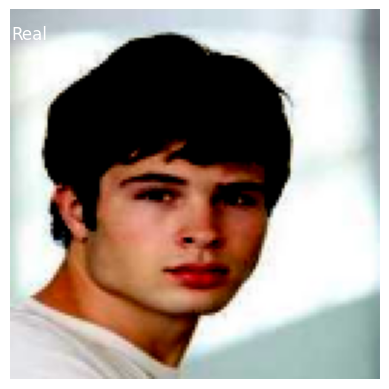

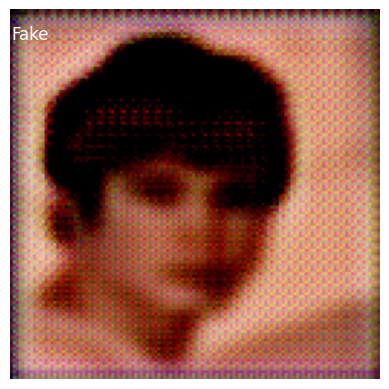

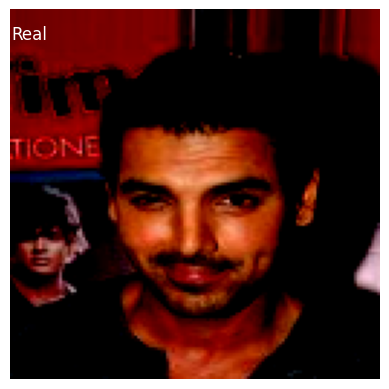

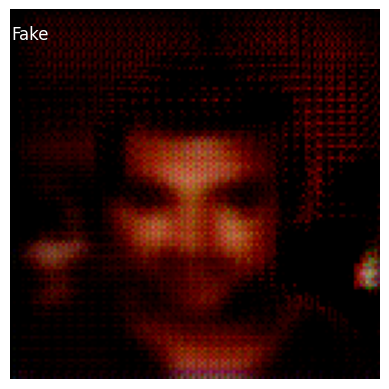

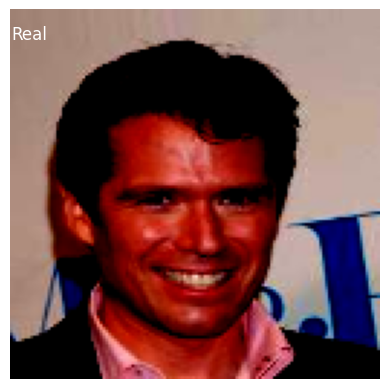

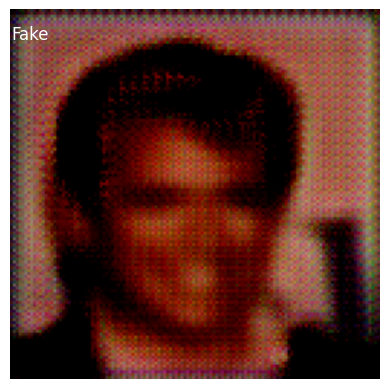

<Figure size 640x480 with 0 Axes>

In [26]:
if __name__ == '__main__':

    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

    parser.add_argument('--batchSize', type=int, default=1, help='Batch Size to be used for training')
    parser.add_argument('--data_dir', type=str, default='../output/kaggle/working', help='Directory where train and test images are present')

    opt, _ = parser.parse_known_args()

    data_dir = opt.data_dir
    batch_size = opt.batchSize

    print("Data_dir:{}".format(data_dir))
    print("BatchSize:{}".format(batch_size))

    genA2B = define_generator_network()
    genB2A = define_generator_network()

    genA2B.load_weights("generatorAToB.h5")
    genB2A.load_weights("generatorBToA.h5")
    
    men_with_glasses_dir = 'men_with_glasses_test'
    men_without_glasses_dir = 'men_without_glasses_test'
    testA, testB = load_test_images(men_with_glasses_dir,men_without_glasses_dir, num_images=5)

    # Generate images
    fakeB = genA2B.predict(testA)
    fakeA = genB2A.predict(testB)

    # Get reconstructed images
    reconsA = genB2A.predict(fakeB)
    reconsB = genA2B.predict(fakeA)

    identityA = genB2A.predict(testA)
    identityB = genA2B.predict(testB)

    save_test_results(testA, testB, fakeA, fakeB, reconsA, reconsA, identityA, identityB)